In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
from scipy import signal

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Position and Direction Estimation using Phase Difference of Arrival

For nodes that are spaced closer together the timing requirments for high accuracy positiong via Time Difference of Arrival are not achivable with existing low cost systems.  Instead the Phase Difference of Arrival can be employed as it is in the Bluetooth 5.1v specification.  Here the PDoA can be used to accuratly estimate the direction from a node to an RF source.  Additional accuracy is gained with transmitters employing the bluetooth 5.1 continous tone extension.  In dense indoor enviorments however multipath is a significant concern for accuracy in these systems.

This could be used in combination with IMUs on nodes to allow for a node to guide a user to it.  The node knows its orintation in world space using its IMU.  Similarly a user with a cell phone has a worldspace orientation from the phone IMU.  Then knowing the direction of arrival of bluetooth signals from the phone the node can report the world space vector from itself to the cellphone.  The cellphone can then direct a user in the direction of the node.  This could assist with located displaced nodes more quickly than simply searching by RSSI.

In a secure space unauthorized transmitters could be localized and reported to security systems employing the same PDoA method, having several of the nodes give vectors to the detected unauthorized RF source to estimate its position.

Define the RF Parameters

In [2]:
center_frequency = 915e6
bandwidth = 10e3

In [3]:
pulse_length = 100e-6

Defining the positions of 3 nodes.  A target node (a), and 2 listening nodes (b, c).

In [4]:
class Node():

    def __init__(self, name, x, y):

        self.name = name

        self.x = x
        self.y = y

    def euclidian(self, b):
        return np.sqrt((self.x - b.x)**2 + (self.y - b.y)**2)

    def plot_point(self, ax):
        ax.plot(self.x, self.y, 'o', label=self.name)

    def delay(self, b):
        dist = self.euclidian(b)
        delay = dist / constants.c
        return delay

In [5]:
radius = 15
angles = np.linspace(0, np.pi / 2, 19)
targets = []
for ang in angles:
    targets.append(Node(f'{np.degrees(ang):0.0f}°', radius*np.sin(ang), radius*np.cos(ang)))

a = Node('A', -0.1, 0.0)
b = Node('B',  0.1, 0.0)

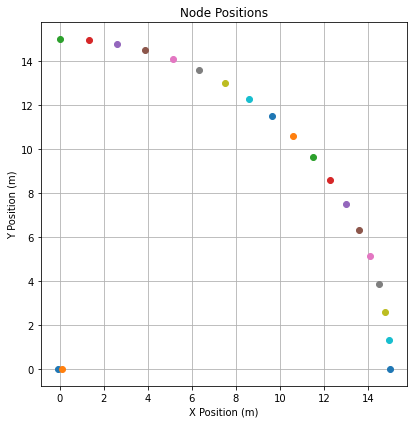

In [6]:
plt.figure(figsize=(6,6))

ax = plt.gca()

ax.set_title('Node Positions')
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')

a.plot_point(ax)
b.plot_point(ax)

for node in targets:
    node.plot_point(ax)

ax.grid()
ax.set_aspect('equal')
plt.tight_layout()

In [7]:
ab_time = a.delay(b)

In [8]:
def calculate_TDoA(target):

    # Generate RF pulses as received by b and c

    fs = 10e9 # 10 GSPS to contain RF spectral content cleanly

    # Calculate pulse arrival times
    a_time = target.delay(a)
    b_time = target.delay(b)

    # create enough sample time to have last pulse in middle
    max_time = 2 * ( max(a_time, b_time) + pulse_length )

    t = np.arange(0, max_time, 1/fs)

    # compute delays
    a_phi = 2*np.pi*center_frequency * a_time
    b_phi = 2*np.pi*center_frequency * b_time

    pulse_length_samples = pulse_length * fs

    # create reference RF energy
    x_a = np.sin(2*np.pi*center_frequency*t - a_phi)
    x_b = np.sin(2*np.pi*center_frequency*t - b_phi)

    x_a[np.where(np.logical_or(t < a_time, t > a_time + pulse_length))] = 0
    x_b[np.where(np.logical_or(t < b_time, t > b_time + pulse_length))] = 0

    """
    plt.figure()
    plt.plot(t, x_a)
    plt.plot(t, x_b)
    plt.xlim(0.0000000425, 0.0000000475)
    plt.tight_layout()
    """

    bb_frequency = 250e3
    lo_frequency = center_frequency - bb_frequency

    sos = signal.butter(1, bb_frequency*2, 'lp', fs=fs, output='sos')

    x_a_bb = signal.sosfilt(sos, x_a * np.sin(2*np.pi*lo_frequency*t))
    x_b_bb = signal.sosfilt(sos, x_b * np.sin(2*np.pi*lo_frequency*t))

    """
    plt.figure()
    plt.plot(t, x_a_bb)
    plt.plot(t, x_b_bb)
    plt.grid()
    plt.xlim(0.0, 0.00002)
    plt.tight_layout()
    """

    ang_diff = np.angle(signal.hilbert(x_a_bb)) - np.angle(signal.hilbert(x_b_bb))
    ang_diff = (ang_diff + np.pi) % (2 * np.pi) - np.pi

    """
    plt.figure()
    plt.plot(t, ang_diff)

    plt.xlim(0.00001, 0.00008)
    plt.tight_layout()
    """

    k = constants.c / center_frequency / a.euclidian(b)

    avg_ang = np.mean(ang_diff[np.where(np.logical_and(t > 0.00001, t < 0.00008))])

    ang = -avg_ang
    if ang < 0:
        ang = 2*np.pi + ang
    ang = np.arcsin( np.clip(ang*k/2/np.pi, 0, 1) )
    
    return ang

In [9]:
avg_angs = []
for target in targets:
    avg_angs.append(calculate_TDoA(target))

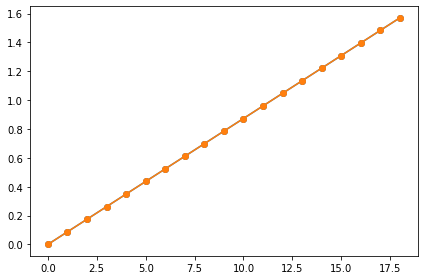

In [10]:
plt.figure()
plt.plot(angles, 'o-')
plt.plot(avg_angs, 'o-')
plt.tight_layout()

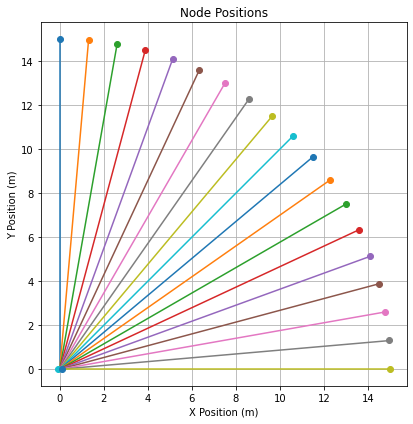

In [11]:
plt.figure(figsize=(6,6))

ax = plt.gca()

ax.set_title('Node Positions')
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')

for node in targets:
    node.plot_point(ax)

r = np.linspace(0, 15, 2)
for i, ang in enumerate(avg_angs):
    ax.plot(r*np.sin(ang), r*np.cos(ang), color=colors[i%len(colors)])

a.plot_point(ax)
b.plot_point(ax)
    
ax.grid()
ax.set_aspect('equal')
plt.tight_layout()